In [ ]:
from google.colab import drive
from IPython.display import clear_output

# 1. Montar Google Drive para acceder a nuestros archivos guardados
print("Conectando con Google Drive...")
drive.mount('/content/drive')

# 2. Instalar la librería de YOLOv8
print("\nInstalando Ultralytics...")
!pip install ultralytics pandas -q  # Instala ultralytics y pandas (para la leyenda)

clear_output()
print("✅ Entorno listo y Google Drive conectado.")

✅ Entorno listo y Google Drive conectado.


In [ ]:
from ultralytics import YOLO
import os

# --- Ruta a tu mejor modelo en Google Drive ---
# Este fue el modelo con el mAP50 más alto
model_path = '/content/drive/MyDrive/YOLOv8_Training/Coffee_Seg_L-Model_StableAug_1088px_Batch16_v1/weights/best.pt'
#model_path = '/content/drive/MyDrive/YOLOv8_Training/Coffee_Seg_n-Model_StableAug_720px_Batch16_v1n/weights/best.pt'

# Verificar si el archivo del modelo existe antes de cargarlo
if os.path.exists(model_path):
    print("Cargando el modelo... (Esto puede tardar unos segundos en CPU)")
    # Cargar los pesos entrenados en el modelo
    model = YOLO(model_path)
    print("✅ Modelo cargado exitosamente.")
else:
    print(f"❌ ¡Error! No se encontró el archivo del modelo en la ruta: {model_path}")
    print("Asegúrate de que la ruta sea correcta.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Cargando el modelo... (Esto puede tardar unos segundos en CPU)
✅ Modelo cargado exitosamente.


--- Leyenda de Colores para las Predicciones ---


Color,Clase
,Maduro
,Pinton
,Seco
,Sobremaduro
,Verde



Por favor, selecciona una imagen para analizar:


Saving Adobe Express - file.jpg to Adobe Express - file.jpg

Procesando la imagen: Adobe Express - file.jpg...

📊 --- Resumen Estadístico --- 📊
Total de Granos Detectados: 12
  - Sobremaduro: 12

Resultados (Confianza >= 10%)
Imagen Original  |  Estilo 1 (Máscara)  |  Estilo 2 (Contorno)


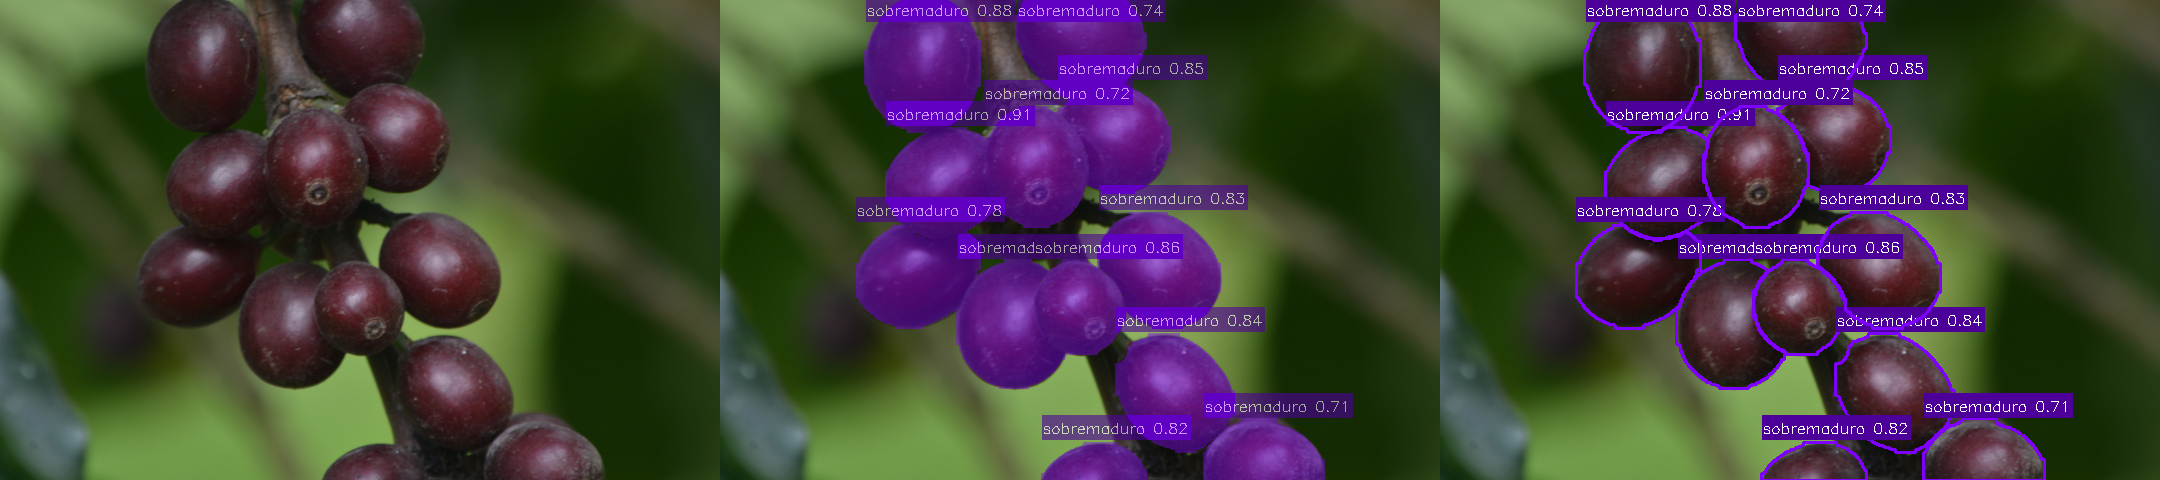

In [ ]:
import cv2
import numpy as np
import pandas as pd
from google.colab import files
from google.colab.patches import cv2_imshow
from IPython.display import display, HTML
from ultralytics import YOLO
# --- 0. Configuración ---
conf_threshold = 0.10 # Umbral de confianza MÍNIMO para MOSTRAR una predicción
iou_bbox_threshold = 0.5 # Umbral IoU para NMS INTERNO basado en BBox (valor estándar)
mask_iou_threshold = 0.1 #

# --- 1. Definir la leyenda de colores ---
try:
    class_names = model.names
except NameError:
    print("❌ Error: Asegúrate de haber cargado el modelo en una celda anterior.")
    raise

colors = {
    'maduro': (0, 0, 255),      # Rojo
    'pinton': (0, 255, 255),   # Amarillo
    'verde': (0, 255, 0),      # Verde
    'sobremaduro': (255, 0, 128), # Morado
    'seco': (0, 75, 150)       # Marrón
}

legend_data = []
for i, name in class_names.items():
    if name in colors:
        b, g, r = colors[name] # Colores en formato BGR
        color_box = f'<div style="width:20px; height:20px; background-color:rgb({r},{g},{b}); border: 1px solid black; display: inline-block; vertical-align: middle; margin-right: 5px;"></div>'
        legend_data.append([color_box, name.capitalize()])

legend_df = pd.DataFrame(legend_data, columns=['Color', 'Clase'])
print("--- Leyenda de Colores para las Predicciones ---")
display(HTML(legend_df.to_html(escape=False, index=False)))


# --- Funciones auxiliares para NMS basado en máscaras ---
def calculate_mask_iou(mask1_coords, mask2_coords, img_shape):
    mask1_img = np.zeros(img_shape[:2], dtype=np.uint8)
    mask2_img = np.zeros(img_shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask1_img, [mask1_coords.astype(np.int32)], 1) # Asegurar int32
    cv2.fillPoly(mask2_img, [mask2_coords.astype(np.int32)], 1) # Asegurar int32
    intersection = np.logical_and(mask1_img, mask2_img).sum()
    union = np.logical_or(mask1_img, mask2_img).sum()
    if union == 0: return 0.0
    return intersection / union

def apply_mask_nms(detections, img_shape, iou_threshold):
    if not detections: return []
    detections = sorted(detections, key=lambda x: x['confidence'], reverse=True)
    keep_indices = []
    suppressed = np.zeros(len(detections), dtype=bool)
    for i in range(len(detections)):
        if suppressed[i]: continue
        keep_indices.append(i)
        for j in range(i + 1, len(detections)):
            if suppressed[j]: continue
            iou = calculate_mask_iou(detections[i]['mask_coords'], detections[j]['mask_coords'], img_shape)
            if iou >= iou_threshold:
                suppressed[j] = True
    final_detections = [detections[idx] for idx in keep_indices]
    return final_detections


# --- 2. Subir una imagen desde la PC ---
print("\nPor favor, selecciona una imagen para analizar:")
uploaded = files.upload()

if not uploaded:
    print("\nNo se seleccionó ningún archivo.")
else:
    for filename in uploaded.keys():
        image_path = filename
        print(f"\nProcesando la imagen: {image_path}...")

        # --- 3. Realizar la predicción (con NMS de BBox estándar) ---
        # conf bajo para capturar candidatos, NMS de BBox ayuda un poco
        results = model(image_path, conf=0.01, iou=iou_bbox_threshold, verbose=False)
        result = results[0]

        original_img = cv2.imread(image_path)
        img_shape = original_img.shape
        img_style_2 = original_img.copy() # Para Máscara + Texto
        img_style_3 = original_img.copy() # Para Contorno + Texto
        overlay = original_img.copy()

        # --- 4. Recopilar, aplicar NMS de máscaras y dibujar ---
        raw_detections = []
        if result.masks is not None and result.boxes is not None:
            for i in range(len(result.boxes)):
                confidence = float(result.boxes.conf[i])
                if confidence >= conf_threshold: # Filtrado inicial por confianza
                    cls_id = int(result.boxes.cls[i])
                    if i < len(result.masks.xy): # Asegurar máscara
                        raw_detections.append({
                            'confidence': confidence,
                            'cls_id': cls_id,
                            'class_name': model.names[cls_id],
                            'bbox': result.boxes.xyxy[i].cpu().numpy().astype(int),
                            'mask_coords': result.masks.xy[i].astype(int),
                            'color': colors.get(model.names[cls_id], (255, 255, 255))
                        })

        # Aplicar NMS basado en IoU de máscaras MÁS ESTRICTO
        final_detections = apply_mask_nms(raw_detections, img_shape, mask_iou_threshold)

        #Preparar estadísticas ---
        detection_count = 0
        class_counts = {name: 0 for name in model.names.values()}

        if final_detections:
            detection_count = len(final_detections)
            for det in final_detections:
                confidence = det['confidence']
                class_name = det['class_name']
                bbox = det['bbox']
                mask_coords = det['mask_coords']
                color = det['color']

                # --- CAMBIO: Conteo para estadísticas ---
                class_counts[class_name] += 1

                # --- Dibujar ---
                # Dibujar máscara
                cv2.fillPoly(overlay, [mask_coords], color)
                # Dibujar contorno
                cv2.polylines(img_style_3, [mask_coords], isClosed=True, color=color, thickness=2)

                # Dibujar BBox ELIMINADO ---
                # cv2.rectangle(img_style_1, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 2)

                # Escribir texto
                label = f"{class_name} {confidence:.2f}"
                text_y = bbox[1] - 10 if bbox[1] - 10 > 10 else bbox[1] + 15
                text_pos = (bbox[0], text_y)
                font_scale=0.5
                thickness=1
                (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness+1)
                bg_color = (np.array(color) * 0.6).astype(np.uint8).tolist()

                # Quitar texto de img_style_1 ---
                cv2.rectangle(img_style_2, (bbox[0], text_y - text_height - baseline), (bbox[0] + text_width, text_y + baseline), bg_color, -1)
                cv2.rectangle(img_style_3, (bbox[0], text_y - text_height - baseline), (bbox[0] + text_width, text_y + baseline), bg_color, -1)
                cv2.putText(img_style_2, label, text_pos, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)
                cv2.putText(img_style_3, label, text_pos, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

        if detection_count == 0:
            print(f"No se encontraron detecciones con confianza >= {conf_threshold*100:.0f}%.")

        # --- 5. Fusionar y Mostrar ---
        alpha = 0.4

        # Imprimir estadísticas ANTES de las imágenes ---
        print("\n" + "="*50)
        print("📊 --- Resumen Estadístico --- 📊")
        print(f"Total de Granos Detectados: {detection_count}")
        for class_name, count in class_counts.items():
            if count > 0:
                print(f"  - {class_name.capitalize()}: {count}")
        print("="*50 + "\n")

        if detection_count > 0:
            # Aplicar transparencia solo a la imagen de máscara
            img_style_2 = cv2.addWeighted(overlay, alpha, img_style_2, 1 - alpha, 0)

            # Combinar imágenes horizontalmente ---
            # Asegurarse de que todas tengan la misma altura (lo cual deberían por ser copias)
            try:
                combined_image = np.hstack([original_img, img_style_2, img_style_3])

                print("Resultados (Confianza >= {:.0f}%)".format(conf_threshold*100))
                print("Imagen Original  |  Estilo 1 (Máscara)  |  Estilo 2 (Contorno)")
                cv2_imshow(combined_image)

            except ValueError as e:
                print(f"Error al combinar imágenes (np.hstack): {e}")
                print("Mostrando imágenes por separado como plan B:")
                print("\nOriginal:")
                cv2_imshow(original_img)
                print("\nEstilo 1 (Máscara):")
                cv2_imshow(img_style_2)
                print("\nEstilo 2 (Contorno):")
                cv2_imshow(img_style_3)

        else:
            print("\nMostrando imagen original ya que no hubo detecciones válidas.")
            cv2_imshow(original_img)